In [ ]:
# Cài đặt các thư viện cần thiết
!pip install -U vnstock3
!pip install pmdarima
!pip install tensorflow scikit-learn
!pip install matplotlib pandas numpy statsmodels
!pip install seaborn
# Bỏ qua các cảnh báo
import os
import warnings
warnings.filterwarnings('ignore')

# Thư viện chung
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Tùy chỉnh hiển thị biểu đồ
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6

# LSTM và RNN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Thống kê và phân tích chuỗi thời gian (ARIMA)
from statsmodels.tsa.stattools import adfuller  # Kiểm tra độ dừng
from statsmodels.tsa.seasonal import seasonal_decompose  # Phân tích mùa vụ
from statsmodels.tsa.arima.model import ARIMA  # ARIMA model
from pmdarima.arima import auto_arima  # Tìm ARIMA tốt nhất

# Đánh giá hiệu năng mô hình
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.0/93.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.1/201.1 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.2 MB/s eta 0:00:00


In [ ]:
from vnstock3 import Vnstock
stock_data  = Vnstock().stock(symbol='VIC', source='VCI')


    Khi tiếp tục sử dụng Vnstock3, bạn xác nhận rằng bạn đã đọc, hiểu và đồng ý với Chính sách quyền riêng tư và Điều khoản, điều kiện về giấy phép sử dụng Vnstock3.

    Chi tiết:

    - Giấy phép sử dụng phần mềm: https://vnstocks.com/docs/tai-lieu/giay-phep-su-dung
    - Chính sách quyền riêng tư: https://vnstocks.com/docs/tai-lieu/chinh-sach-quyen-rieng-tu
    


2025-01-08 05:45:31 - vnstock3.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS


In [ ]:
df = stock_data.quote.history(start='2020-01-01', end='2024-06-21', interval='1D')
print(df.head(100))

         time    open    high     low   close  volume
0  2020-01-02  102.13  102.22  101.33  102.22  440280
1  2020-01-03  102.22  102.49  101.60  102.49  248940
2  2020-01-06  102.22  102.22  101.69  101.78  301910
3  2020-01-07  101.78  102.22  101.60  101.96  183910
4  2020-01-08  101.78  101.96  100.98  101.60  468910
..        ...     ...     ...     ...     ...     ...
95 2020-05-26   86.22   86.67   85.69   86.13  360000
96 2020-05-27   86.13   87.02   85.78   86.13  591440
97 2020-05-28   86.13   86.67   85.60   86.22  314790
98 2020-05-29   86.22   86.67   85.87   86.22  493500
99 2020-06-01   86.22   86.40   85.78   86.40  481490

[100 rows x 6 columns]


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1115 non-null   datetime64[ns]
 1   open    1115 non-null   float64       
 2   high    1115 non-null   float64       
 3   low     1115 non-null   float64       
 4   close   1115 non-null   float64       
 5   volume  1115 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 52.4 KB


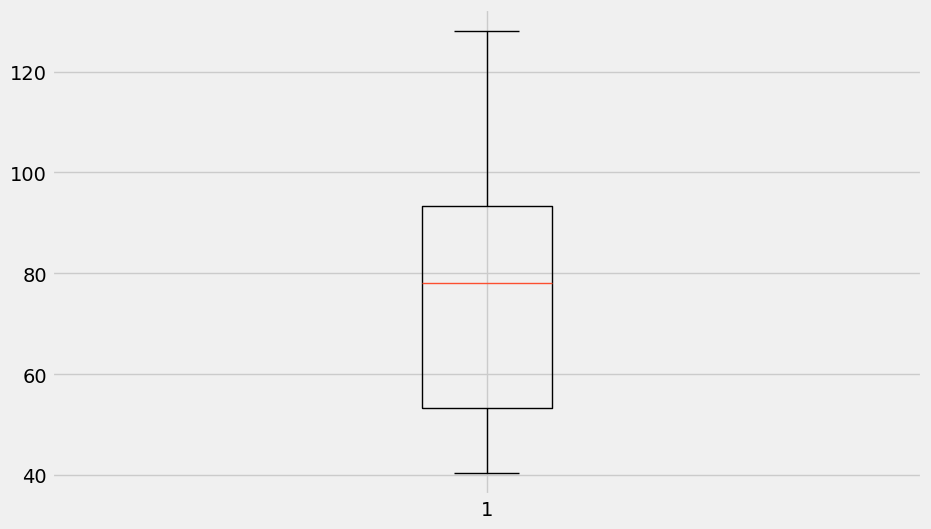

In [ ]:
data_11= df[[ 'close']]

plt.boxplot(data_11)
plt.show()

In [ ]:
# Chỉ giữ lại hai cột 'date' và 'close'
data= df[['time', 'close']]

# Đảm bảo cột 'Date' là kiểu datetime
data['time'] = pd.to_datetime(data['time'])

data.head()

,time,close
0,2020-01-02,102.22
1,2020-01-03,102.49
2,2020-01-06,101.78
3,2020-01-07,101.96
4,2020-01-08,101.60


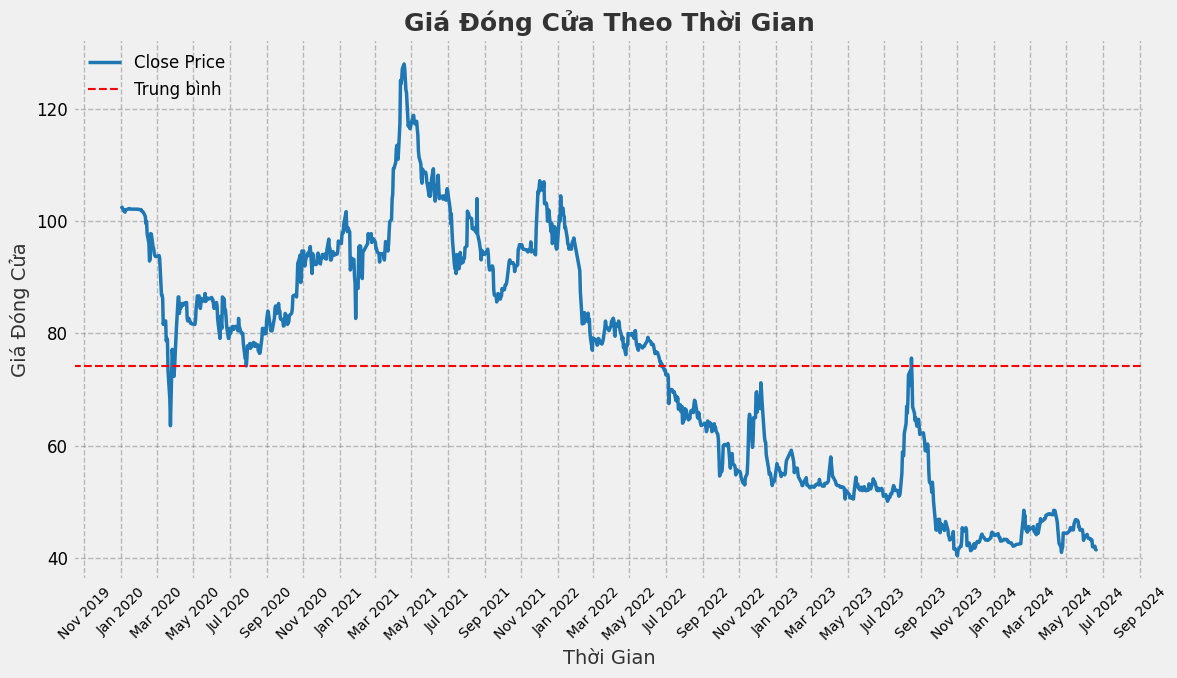

In [ ]:
import matplotlib.dates as mdates

# Tạo biểu đồ
plt.figure(figsize=(12, 7))  # Kích thước biểu đồ
plt.plot(data['time'], data['close'], label='Close Price', color='#1f77b4', linewidth=2.5)

# Tùy chỉnh trục x
if data['time'].dtype.name == 'datetime64[ns]':  # Nếu cột 'time' là dạng thời gian
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # Hiển thị 2 tháng 1 nhãn
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Hiển thị tháng và năm
    plt.xticks(rotation=45, fontsize=10)  # Xoay nhãn 45 độ, giảm kích thước font

# Tùy chỉnh trục y
plt.yticks(fontsize=12)
plt.ylabel('Giá Đóng Cửa', fontsize=14, color='#333')

# Tùy chỉnh biểu đồ
plt.title('Giá Đóng Cửa Theo Thời Gian', fontsize=18, color='#333', fontweight='bold')
plt.xlabel('Thời Gian', fontsize=14, color='#333')
plt.grid(True, linestyle='--', alpha=0.5, color='gray')
plt.axhline(y=data['close'].mean(), color='red', linestyle='--', linewidth=1.5, label='Trung bình')  # Đường trung bình
plt.legend(fontsize=12, loc='upper left', frameon=False)

# Chỉnh bố cục
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()


In [ ]:
data= data[['close']]
data.head()

,close
0,102.22
1,102.49
2,101.78
3,101.96
4,101.60


In [ ]:
from sklearn.preprocessing import MinMaxScaler #chuẩn hóa dữ liệu

scaler = MinMaxScaler(feature_range=(0, 1))
data= scaler.fit_transform(data)
data

array([[0.70570776],
       [0.70878995],
       [0.70068493],
       ...,
       [0.01255708],
       [0.0119863 ],
       [0.01426941]])

In [ ]:
test_len  = 200
train_len = data.shape[0] - test_len
timesteps = 60
features  = 1

X_train = []
y_train = []

for i in range(timesteps, train_len):
  X_train.append(data[i-timesteps:i, :])
  y_train.append(data[i, :])

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

print(X_train.shape, y_train.shape)

(855, 60, 1) (855, 1)


In [ ]:
from tensorflow.keras.layers import Dense, LSTM, Dropout, SimpleRNN

# Model RNN
model_rnn = Sequential()
model_rnn.add(SimpleRNN(128, return_sequences=True, input_shape=(timesteps, features)))
model_rnn.add(SimpleRNN(128, return_sequences=False))
model_rnn.add(Dense(30))
model_rnn.add(Dense(1))

model_rnn.compile(optimizer='adam', loss='mse')

In [ ]:
return_sequences=True


In [ ]:
model_rnn.fit(X_train, y_train, batch_size=64, epochs=6)


Epoch 1/6
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.7718
Epoch 2/6
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0435
Epoch 3/6
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0102
Epoch 4/6
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0032
Epoch 5/6
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0018
Epoch 6/6
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0015


In [ ]:
X_test = []
y_test = []

for i in range(train_len, data.shape[0]):
  X_test.append(data[i-timesteps:i, :])
  y_test.append(data[i, :])

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [ ]:
# Dự đoán với model RNN
y_pred_rnn = model_rnn.predict(X_test)
y_pred_rnn = scaler.inverse_transform(y_pred_rnn)
y_test = scaler.inverse_transform(y_test)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [ ]:
# Tính RMSE (Root Mean Squared Error)
rmse_rnn  = np.sqrt(((y_test - y_pred_rnn) ** 2).mean())
print("RMSE:", rmse_rnn)

# Tính giá trị nhỏ nhất, lớn nhất của y_test
print("Min value of y_test:", y_test.min())
print("Max value of y_test:", y_test.max())

# Tính giá trị trung bình của y_test
mean_y_test_1 = y_test.mean()
print("Mean value of y_test:", mean_y_test_1)

# Tính tỷ lệ RMSE trên giá trị trung bình của y_test
rmse_ratio_rnn = rmse_rnn / mean_y_test_1
print("RMSE ratio:", rmse_ratio_rnn)

# Tính MAE (Mean Absolute Error)
mae_rnn  = np.mean(np.abs(y_test - y_pred_rnn))
print("MAE:", mae_rnn)


RMSE: 3.728527752661211
Min value of y_test: 40.4
Max value of y_test: 62.3
Mean value of y_test: 45.261
RMSE ratio: 0.08237837769075386
MAE: 2.8299494972229007


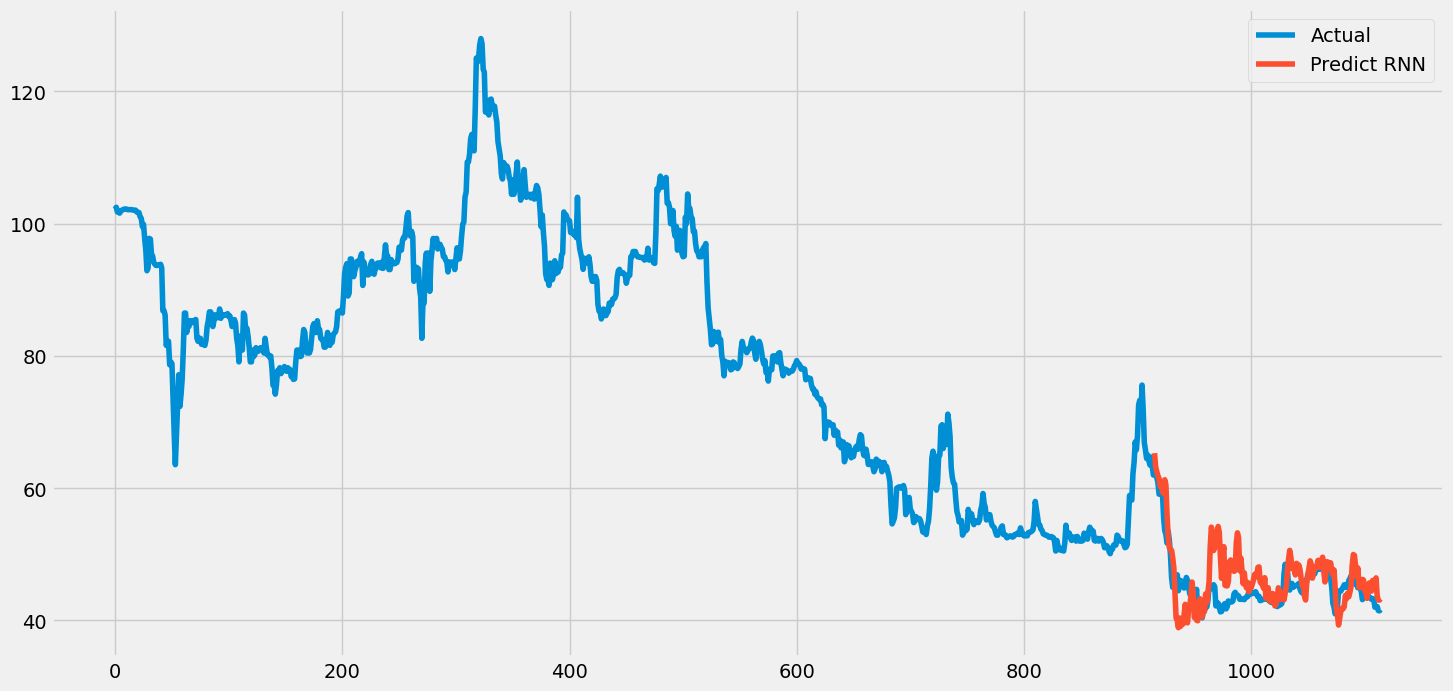

In [ ]:
actual = df[['close']]
pred_rnn = df[['close']].iloc[train_len:, :]
pred_rnn[['Predict RNN']] = y_pred_rnn
plt.figure(figsize=(16, 8))
plt.plot(actual, label='Actual')
plt.plot(pred_rnn[['Predict RNN']], label='Predict RNN')
plt.legend()
plt.show()

In [ ]:
# Model LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(128, return_sequences=True, input_shape=(timesteps, features)))
model_lstm.add(LSTM(128, return_sequences=False))
model_lstm.add(Dense(30))
model_lstm.add(Dense(1))

model_lstm.compile(optimizer='adam', loss='mse')

In [ ]:
model_lstm.fit(X_train, y_train, batch_size=64, epochs=6)


Epoch 1/6
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 214ms/step - loss: 0.0697
Epoch 2/6
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 213ms/step - loss: 0.0068
Epoch 3/6
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 337ms/step - loss: 0.0039
Epoch 4/6
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 214ms/step - loss: 0.0021
Epoch 5/6
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 212ms/step - loss: 0.0018
Epoch 6/6
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 329ms/step - loss: 0.0017


In [ ]:
# Dự đoán với model LSTM
y_pred_lstm = model_lstm.predict(X_test)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step


In [ ]:
# Tính RMSE (Root Mean Squared Error)
rmse_lstm   = np.sqrt(((y_test - y_pred_lstm) ** 2).mean())
print("RMSE:", rmse_lstm )

# Tính giá trị nhỏ nhất, lớn nhất của y_test
print("Min value of y_test:", y_test.min())
print("Max value of y_test:", y_test.max())

# Tính giá trị trung bình của y_test
mean_y_test_1 = y_test.mean()
print("Mean value of y_test:", mean_y_test_1)

# Tính tỷ lệ RMSE trên giá trị trung bình của y_test
rmse_ratio_lstm = rmse_lstm  / mean_y_test_1
print("RMSE ratio:", rmse_ratio_lstm)

# Tính MAE (Mean Absolute Error)
mae_lstm  = np.mean(np.abs(y_test - y_pred_lstm))
print("MAE:", mae_lstm)


RMSE: 2.2019882334912633
Min value of y_test: 40.4
Max value of y_test: 62.3
Mean value of y_test: 45.261
RMSE ratio: 0.04865089665476377
MAE: 1.5051199455261226


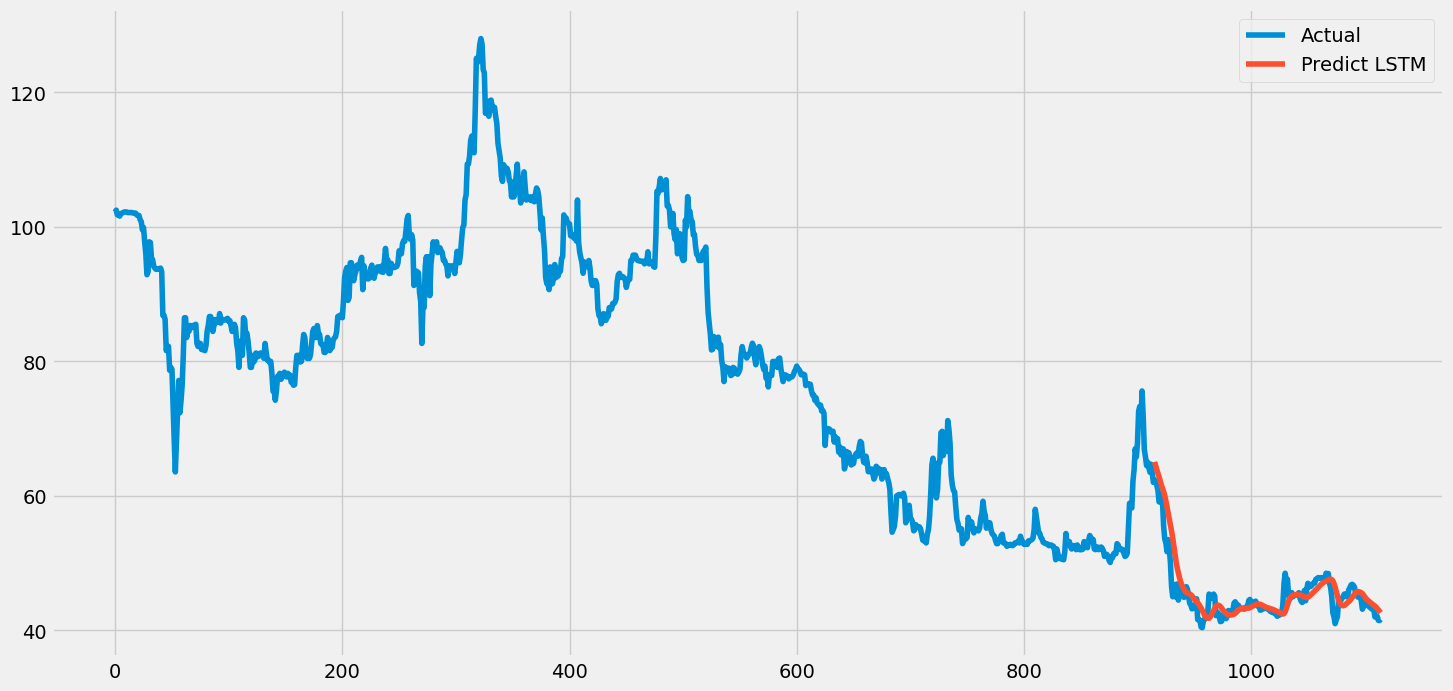

In [ ]:
actual = df[['close']]
pred_lstm = df[['close']].iloc[train_len:, :]
pred_lstm[['Predict LSTM']] = y_pred_lstm
plt.figure(figsize=(16, 8))
plt.plot(actual, label='Actual')
plt.plot(pred_lstm[['Predict LSTM']], label='Predict LSTM')
plt.legend()
plt.show()

In [ ]:
data_10= df[['close']]
data_10.head()

,close
0,102.22
1,102.49
2,101.78
3,101.96
4,101.60


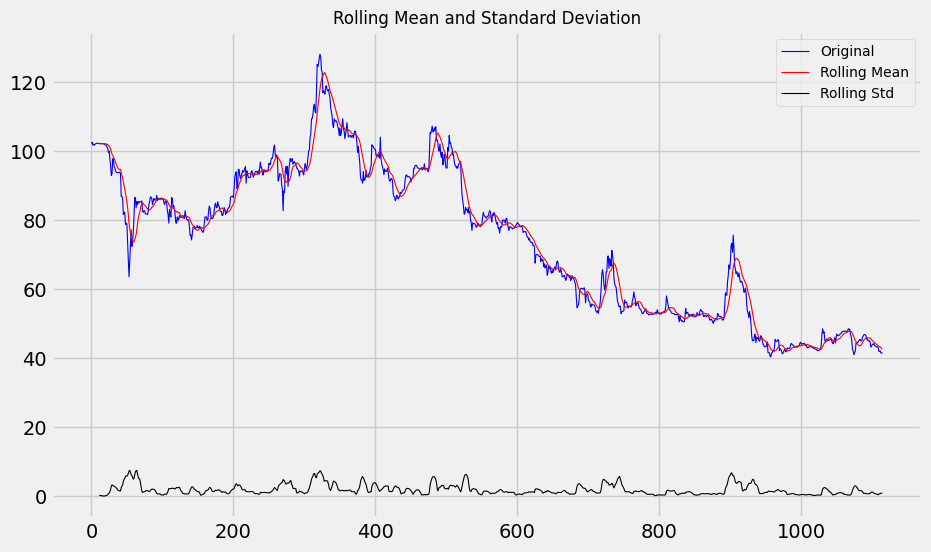

Results of Dickey-Fuller test
Test Statistics                  -1.173514
p-value                           0.684884
No. of lags used                  1.000000
Number of observations used    1113.000000
critical value (1%)              -3.436239
critical value (5%)              -2.864140
critical value (10%)             -2.568154
dtype: float64


In [ ]:
# Test for stationarity with thinner lines and smaller fonts
def test_stationarity(timeseries):
    # Determining rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    # Plot rolling statistics with thinner lines
    plt.figure(figsize=(10, 6))  # Adjust figure size if needed
    plt.plot(timeseries, color='blue', label='Original', linewidth=0.8)  # Thin blue line
    plt.plot(rolmean, color='red', label='Rolling Mean', linewidth=0.8)  # Thin red line
    plt.plot(rolstd, color='black', label='Rolling Std', linewidth=0.8)  # Thin black line
    plt.legend(loc='best', fontsize=10)  # Smaller font for legend
    plt.title('Rolling Mean and Standard Deviation', fontsize=12)  # Smaller title
    plt.show(block=False)

    # Print results of Dickey-Fuller test
    print("Results of Dickey-Fuller test")
    adft = adfuller(timeseries, autolag='AIC')
    output = pd.Series(adft[0:4], index=['Test Statistics', 'p-value', 'No. of lags used', 'Number of observations used'])
    for key, values in adft[4].items():
        output['critical value (%s)' % key] = values
    print(output)

test_stationarity(data_10)


<Figure size 1000x600 with 0 Axes>

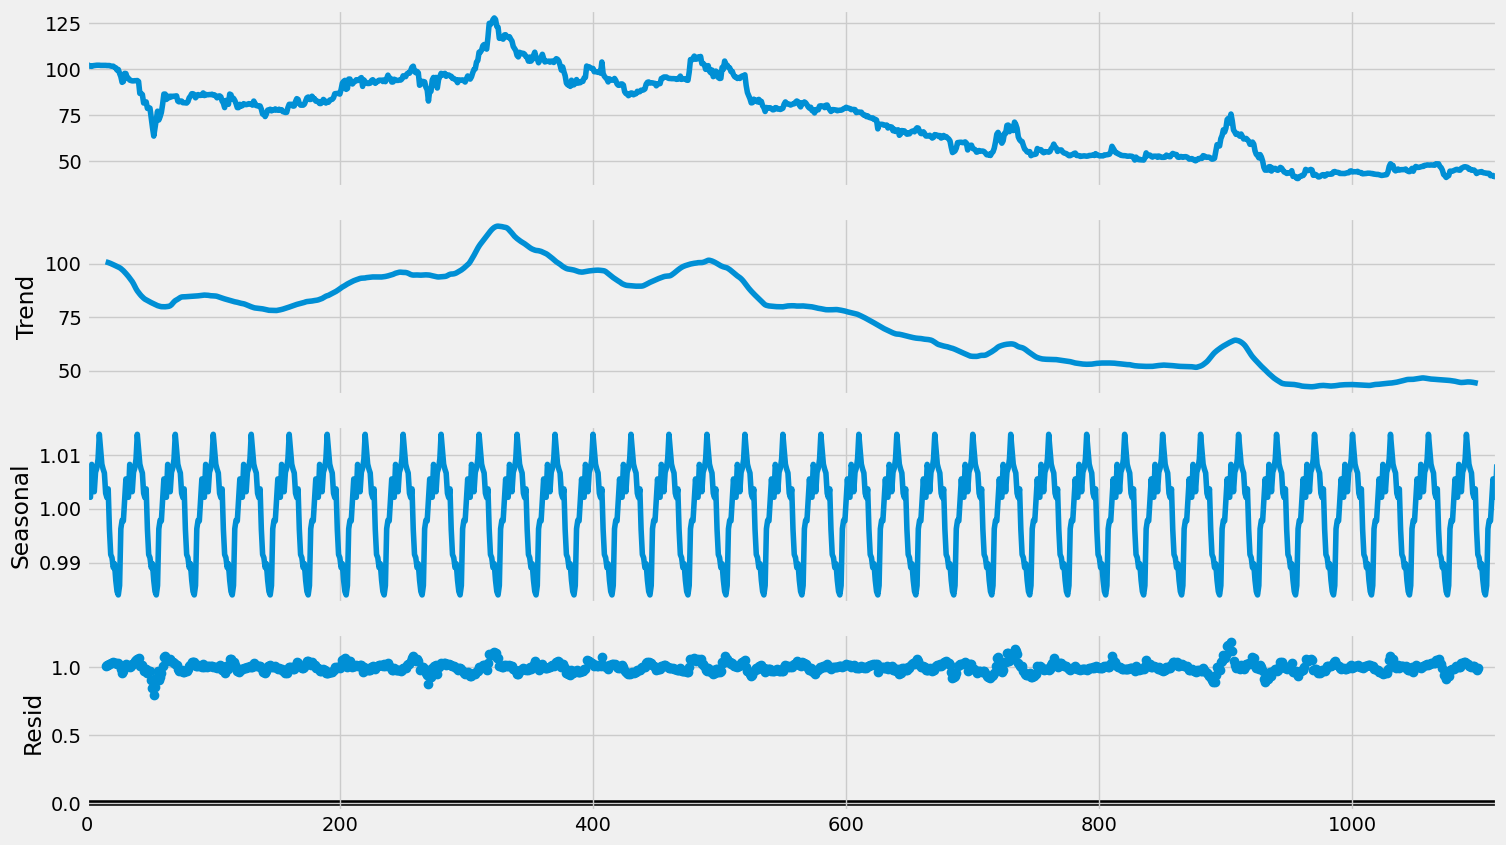

In [ ]:
#To separate the trend and the seasonality from a time series,
# we can decompose the series using the following code.
result = seasonal_decompose(data_10, model='multiplicative', period=30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)
plt.show()

In [ ]:
df_log = np.log(data_10)                     # Log transformation
moving_avg = df_log.rolling(12).mean()  # Tính trung bình động
df_log_detrend = df_log - moving_avg    # Loại bỏ xu hướng
df_log_detrend.dropna(inplace=True)     # Loại bỏ NaN


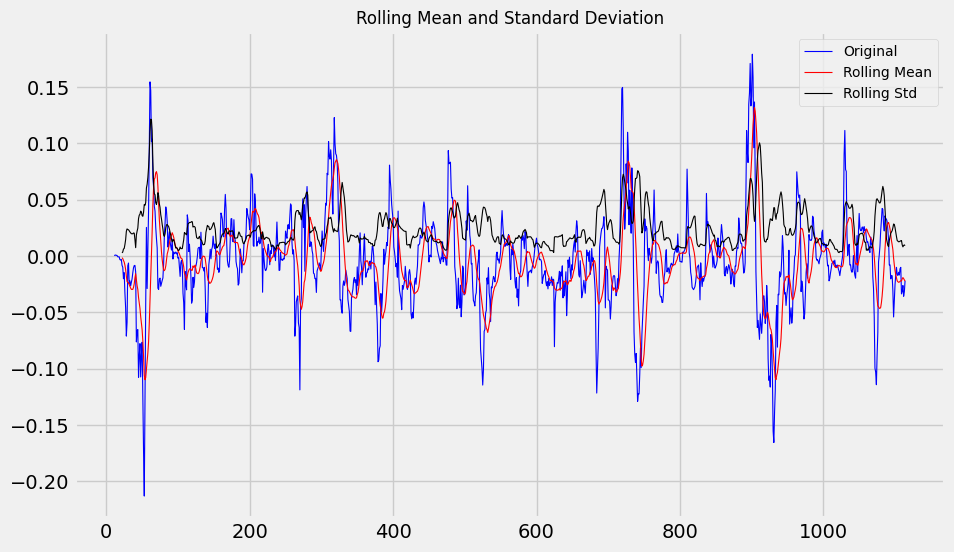

Results of Dickey-Fuller test
Test Statistics               -9.676820e+00
p-value                        1.234443e-16
No. of lags used               6.000000e+00
Number of observations used    1.097000e+03
critical value (1%)           -3.436325e+00
critical value (5%)           -2.864178e+00
critical value (10%)          -2.568175e+00
dtype: float64


In [ ]:
test_stationarity(df_log_detrend)


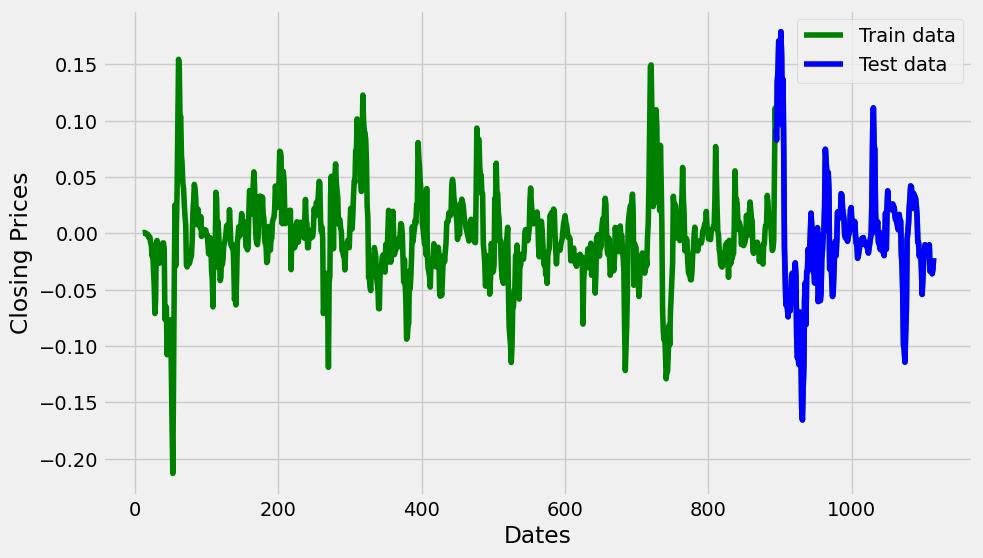

In [ ]:
#split data into train and training set
train_data, test_data = df_log_detrend[3:int(len(df_log_detrend)*0.8)], df_log_detrend[int(len(df_log_detrend)*0.8):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log_detrend, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()


Best model:  ARIMA(1,0,2)(0,0,0)[0]          
Total fit time: 9.207 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  880
Model:               SARIMAX(1, 0, 2)   Log Likelihood                2277.323
Date:                Tue, 07 Jan 2025   AIC                          -4546.646
Time:                        15:58:35   BIC                          -4527.527
Sample:                             0   HQIC                         -4539.334
                                - 880                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8219      0.017     48.601      0.000       0.789       0.855
ma.L1          0.1778      0.027      6.647      0.000

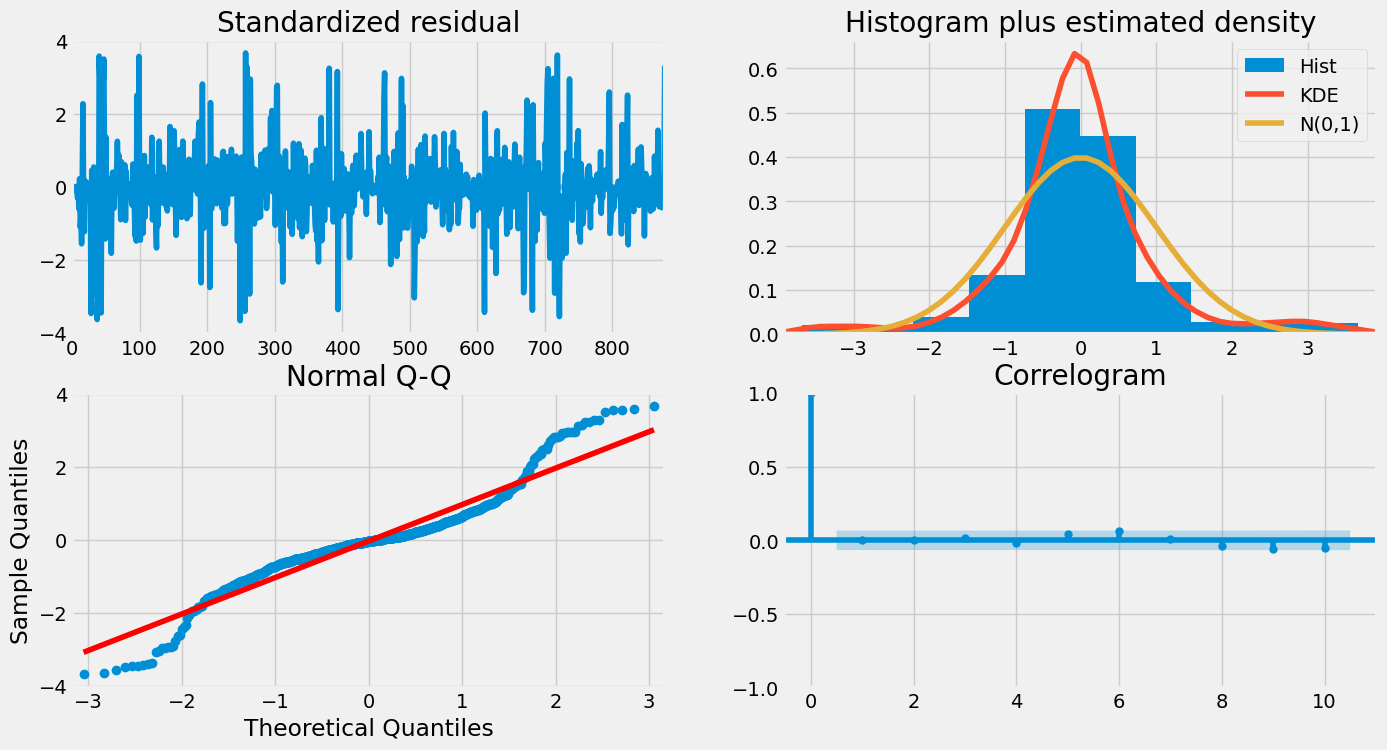

In [ ]:
model_autoARIMA = auto_arima(
    train_data,
    start_p=0, start_q=0, start_d=0,  # Bắt đầu từ giá trị nhỏ nhất
    max_p=10, max_q=10, max_d=5,     # Tăng giới hạn tìm kiếm
    test='adf',                      # Sử dụng kiểm định Dickey-Fuller để tìm 'd'
    m=1,                             # Không có yếu tố thời vụ (m=1)
    seasonal=False,                  # Không xem xét tính thời vụ
    trace=True,                      # Hiển thị thông tin quá trình tìm kiếm
    error_action='ignore',           # Bỏ qua lỗi khi thử nghiệm tham số
    suppress_warnings=True,          # Tắt cảnh báo không cần thiết
    stepwise=False,                  # Tìm kiếm toàn diện (brute-force)
    n_jobs=-1                        # Sử dụng đa luồng để tăng tốc
)

print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [ ]:
# Xây dựng mô hình
model_Arima = ARIMA(train_data, order=(1,0,2))
# Loại bỏ tham số disp=-1.
fitted = model_Arima.fit()
print(fitted.summary())

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  880
Model:                 ARIMA(1, 0, 2)   Log Likelihood                2277.617
Date:                Tue, 07 Jan 2025   AIC                          -4545.233
Time:                        15:58:50   BIC                          -4521.334
Sample:                             0   HQIC                         -4536.094
                                - 880                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0033      0.004     -0.757      0.449      -0.012       0.005
ar.L1          0.8197      0.017     47.578      0.000       0.786       0.853
ma.L1          0.1793      0.027      6.684      0.0

In [ ]:
# Dự báo đã được sửa
forecast_result = fitted.get_forecast(steps=len(df_log_detrend) - int(len(df_log_detrend)*0.8)) # số bước dự báo là 321
forecast_values = forecast_result.predicted_mean # lấy ra mảng numpy chứa các giá trị dự báo
conf = forecast_result.conf_int(alpha=0.05)  # khoảng tin cậy 95%

print(forecast_values)
print(conf)

880     0.106306
881     0.091950
882     0.074772
883     0.060691
884     0.049149
          ...   
1096   -0.003330
1097   -0.003330
1098   -0.003330
1099   -0.003330
1100   -0.003330
Name: predicted_mean, Length: 221, dtype: float64
      lower close  upper close
880      0.070704     0.141907
881      0.041627     0.142272
882      0.014770     0.134775
883     -0.005019     0.126402
884     -0.020133     0.118432
...           ...          ...
1096    -0.079406     0.072747
1097    -0.079406     0.072747
1098    -0.079406     0.072747
1099    -0.079406     0.072747
1100    -0.079406     0.072747

[221 rows x 2 columns]


No supported index is available. Prediction results will be given with an integer index beginning at `start`.


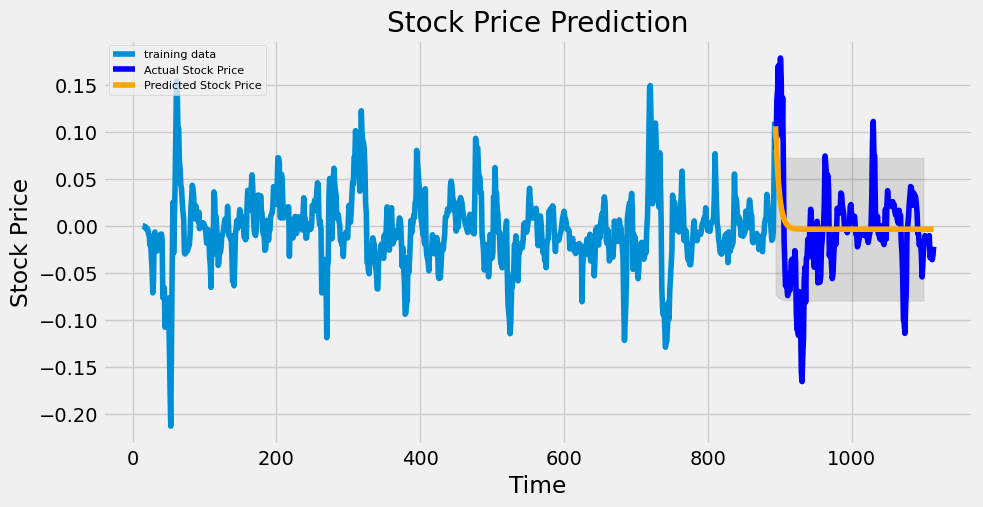

In [ ]:

# Lấy các cột khoảng tin cậy
conf_lower = conf.iloc[:, 0]
conf_upper = conf.iloc[:, 1]
# Đảm bảo giá trị dự báo là một mảng numpy.
fc = forecast_values.to_numpy()
# Tạo series pandas
fc_series = pd.Series(fc, index=test_data.index)
#thay đổi `conf[:,0]` và `conf[:,1]` để sử dụng iloc
lower_series = pd.Series(conf_lower, index=test_data.index)
upper_series = pd.Series(conf_upper, index=test_data.index)
# Vẽ đồ thị
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.10)
plt.title( 'Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
# Calculate MAE
mae = mean_absolute_error(test_data, fc_series)
print(f'MAE: {mae}')
# Calculate MAPE
mape = mean_absolute_percentage_error(test_data, fc_series)
print(f'MAPE: {mape}')
# Calculate RMSE
rmse = math.sqrt(mean_squared_error(test_data, fc_series))
print(f'RMSE: {rmse}')

MAE: 0.03388346595647959
MAPE: 1.3853124615722157
RMSE: 0.04759296274632852


In [ ]:
df_1= stock_data.quote.history(start='2024-05-01', end='2024-06-20', interval='1D')
data_10= df_1[['close']]

data_10

,close
0,44.40
1,44.45
2,44.75
3,45.00
4,45.40
5,45.40
6,45.00
7,45.00
8,46.05
9,46.35


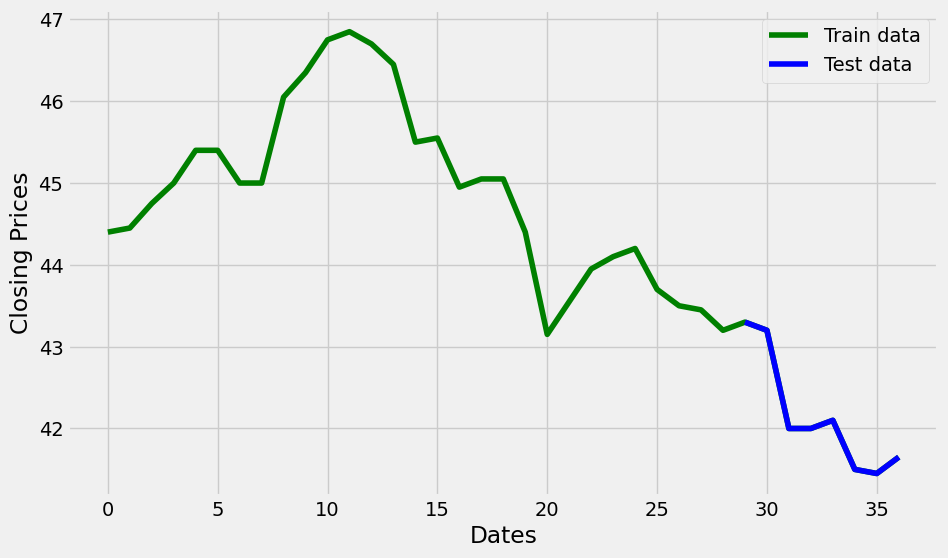

In [ ]:
#split data into train and training set
train_data, test_data = data_10[3:int(len(data_10)*0.8)], data_10[int(len(data_10)*0.8):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(data_10, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [ ]:
model_autoARIMA_1= auto_arima(
    train_data,
    start_p=0, start_q=0, start_d=0,  # Bắt đầu từ giá trị nhỏ nhất
    max_p=10, max_q=10, max_d=5,     # Tăng giới hạn tìm kiếm
    test='adf',                      # Sử dụng kiểm định Dickey-Fuller để tìm 'd'
    m=1,                             # Không có yếu tố thời vụ (m=1)
    seasonal=False,                  # Không xem xét tính thời vụ
    trace=True,                      # Hiển thị thông tin quá trình tìm kiếm
    error_action='ignore',           # Bỏ qua lỗi khi thử nghiệm tham số
    suppress_warnings=True,          # Tắt cảnh báo không cần thiết
    stepwise=False,                  # Tìm kiếm toàn diện (brute-force)
    n_jobs=-1                        # Sử dụng đa luồng để tăng tốc
)

print(model_autoARIMA_1.summary())



Best model:  ARIMA(1,2,0)(0,0,0)[0] intercept
Total fit time: 8.418 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   26
Model:               SARIMAX(1, 2, 0)   Log Likelihood                 -20.715
Date:                Wed, 08 Jan 2025   AIC                             47.430
Time:                        05:46:01   BIC                             50.964
Sample:                             0   HQIC                            48.367
                                 - 26                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0283      0.152     -0.186      0.853      -0.327       0.270
ar.L1         -0.3160      0.201     -1.573      0.116

In [ ]:
# Xây dựng mô hình
model_Arima_1 = ARIMA(train_data, order=(1,2,0))
# Loại bỏ tham số disp=-1.
fitted = model_Arima_1.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                   26
Model:                 ARIMA(1, 2, 0)   Log Likelihood                 -20.744
Date:                Wed, 08 Jan 2025   AIC                             45.487
Time:                        05:53:03   BIC                             47.843
Sample:                             0   HQIC                            46.112
                                 - 26                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3158      0.202     -1.563      0.118      -0.712       0.080
sigma2         0.3284      0.094      3.492      0.000       0.144       0.513
Ljung-Box (L1) (Q):                   0.23   Jarque-

In [ ]:
# Dự báo đã được sửa
forecast_result = fitted.get_forecast(steps=len(data_10) - int(len(data_10)*0.8)) # số bước dự báo là 321
forecast_values = forecast_result.predicted_mean # lấy ra mảng numpy chứa các giá trị dự báo
conf = forecast_result.conf_int(alpha=0.05)  # khoảng tin cậy 95%

print(forecast_values)
print(conf)

29    43.013158
30    42.806372
31    42.605884
32    42.403407
33    42.201558
34    41.999510
35    41.797526
36    41.595521
Name: predicted_mean, dtype: float64
    lower close  upper close
29    41.890042    44.136274
30    40.606510    45.006234
31    39.067038    46.144729
32    37.343096    47.463717
33    35.447488    48.955628
34    33.398097    50.600924
35    31.206240    52.388811
36    28.881606    54.309436


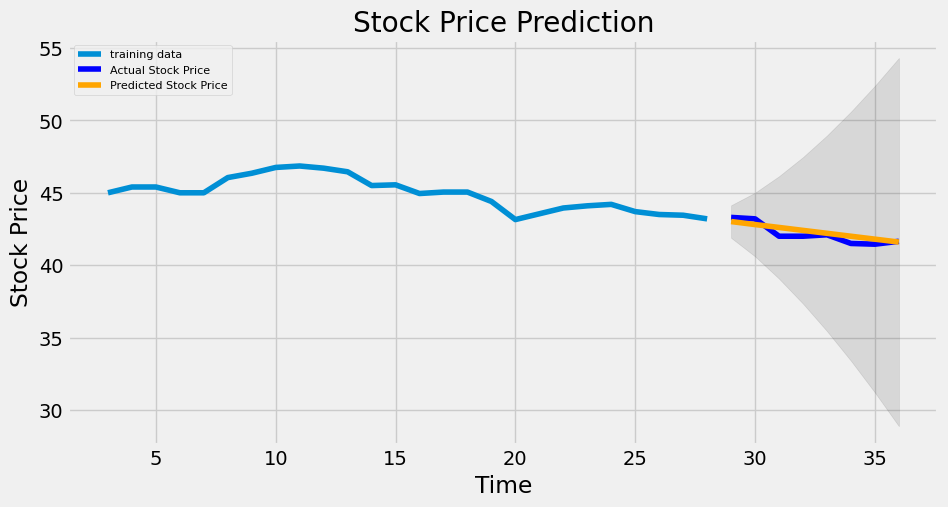

In [ ]:

# Lấy các cột khoảng tin cậy
conf_lower = conf.iloc[:, 0]
conf_upper = conf.iloc[:, 1]
# Đảm bảo giá trị dự báo là một mảng numpy.
fc = forecast_values.to_numpy()
# Tạo series pandas
fc_series = pd.Series(fc, index=test_data.index)
#thay đổi `conf[:,0]` và `conf[:,1]` để sử dụng iloc
lower_series = pd.Series(conf_lower, index=test_data.index)
upper_series = pd.Series(conf_upper, index=test_data.index)
# Vẽ đồ thị
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.10)
plt.title( 'Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
print(train_data.tail())  # Xem dữ liệu cuối của train
print(test_data.head())  # Xem dữ liệu đầu của test


    close
28   43.2
29   43.3
30   43.2
31   42.0
32   42.0
    close
33  42.10
34  41.50
35  41.45
36  41.65


In [ ]:
print(train_data.index)
print(test_data.index)
print(forecast_values.index)


RangeIndex(start=3, stop=33, step=1)
RangeIndex(start=33, stop=37, step=1)
RangeIndex(start=33, stop=37, step=1)
